# Requirements

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd

import tempun

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns


from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString


import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [14]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

# Import datasets

In [3]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [3]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIRE["random_dates"] = LIRE.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000), axis=1)

CPU times: user 42.8 s, sys: 1.58 s, total: 44.4 s
Wall time: 46.3 s


In [4]:
# mask
before235 = LIRE["not_before"] < 235

In [15]:
LIRE[LIRE["is_western"]]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
219,EDCS-21300235,"CIL 06, 00882 (p 3777, 4302, 4367) = CIL 06, 3...",Aegyptus,Aegyptus,Al Iskandariyah / Alexandria,"['Al Iskandariyah', 'Alexandria']",20,,"['Augusti/Augustae', 'tituli sacri', 'viri']",tituli sacri,...,9998.65,1002,"[12.395451, 42.021684]",15756.86,large,[faber],1,[],0,"[Production and related workers, transport equ..."
290,EDCS-12800362,"AE 1964, 00222",Aemilia / Regio VIII,Aemilia / Regio VIII,Bagno di Romagna,Bagno di Romagna,200,,"['tituli sacri', 'viri']",tituli sacri,...,41767.45,937,"[11.903398, 43.983123]",17068.12,rural,[],0,[],0,[]
291,EDCS-09300206,"AE 1976, 00204",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
292,EDCS-09300210,"AE 1976, 00208",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['liberti/libertae', 'mulieres', 'tituli sepul...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
293,EDCS-09300215,"AE 1976, 00213",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",100,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137300,EDCS-10700071,"SupIt-12-IC, 00047 = IulCarnicum-02, 00125",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137301,EDCS-10700072,"SupIt-12-IC, 00048 = IulCarnicum-02, 00137",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137302,EDCS-10700073,"SupIt-12-IC, 00049 = IulCarnicum-02, 00134",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
137303,EDCS-10700074,"SupIt-12-IC, 00050 = IulCarnicum-02, 00115",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",25,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]


In [16]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [17]:
len(LIRE[before235])

115926

In [18]:
LIRE[before235]["occups_N"].sum()

4810

In [19]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9172387490465294

In [20]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [21]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [22]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    if len(city_data) > 0:
        city_dict["inscr_N"] = len(city_data)
        inscr_texts = city_data["clean_text_interpretive_word"].tolist()
        inscr_texts = [el for el in inscr_texts if isinstance(el, str)]
        city_dict["inscr_texts_wordlist"] = " ".join(inscr_texts).split()
        city_dict["edcs_ids"] = city_data["EDCS-ID"].tolist()
        city_dict["edh_ids"] = city_data["EDH-ID"].tolist()
        city_dict["inscr_with_occups"] = (city_data["occups_N"]>0).sum()
        city_dict["occups_mask"] = city_data["occups_N"] > 0
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_cats_list"] = [el for sublist in city_data["occups_cats"] for el in sublist]
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [23]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"192 False Name: occups_N, dtype: bool",[],0.0,[]
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [25]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [26]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,geometry,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,POINT (22.93333 38.58333),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,POINT (23.73409 38.08347),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,POINT (23.21970 38.45261),1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"192 False Name: occups_N, dtype: bool",[],0.0,[]
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,POINT (23.42850 37.75007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,POINT (22.35572 38.14795),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# all cities
len(roman_cities)

1388

In [28]:
roman_cities["inscr_N"].sum()

110163.0

In [29]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

856

In [30]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6167146974063401

In [31]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [32]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

657

In [33]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

# Focus on western cities alone - basic explorations (feel free to skip)

In [34]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [35]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])

roman_cities["pop_est_log10"] = np.log10(roman_cities["pop_est"])
roman_cities["inscr_N_log2"] = np.log2(roman_cities["inscr_N"])

roman_cities["occups_N_log"] = np.log2(roman_cities["occups_N"])


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='inscr_N', ylabel='pop_est'>

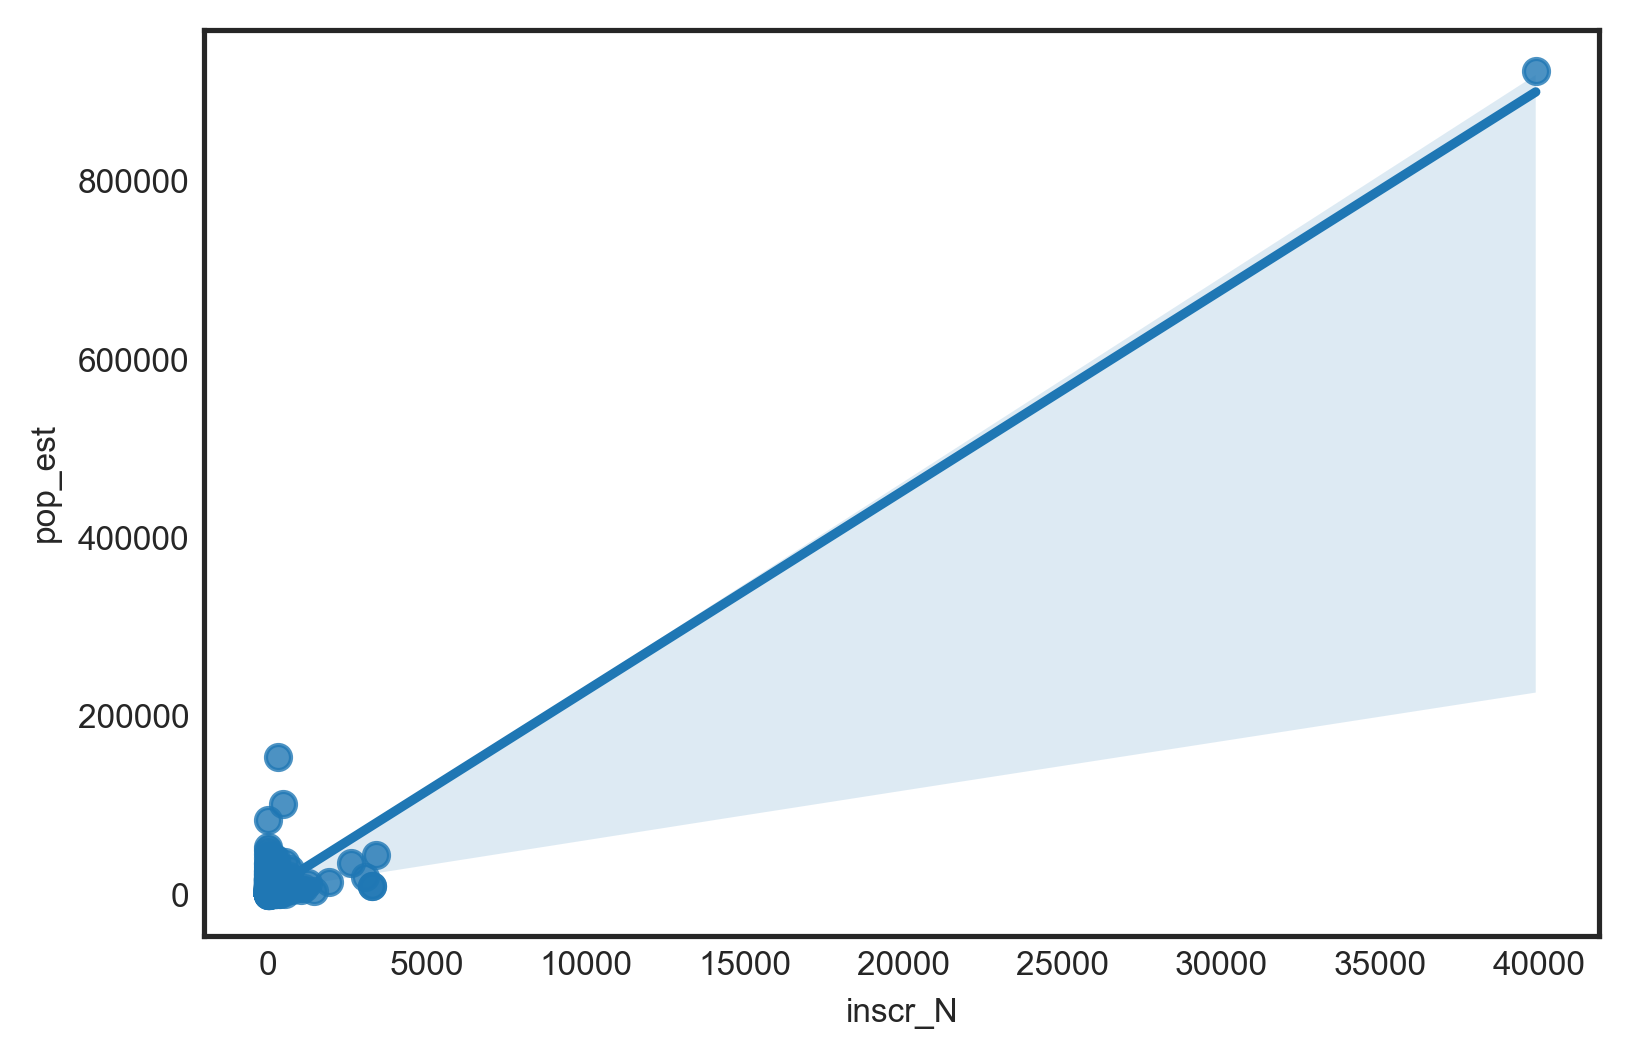

In [36]:
# all cities
data=roman_cities
sns.regplot(x="inscr_N", y="pop_est", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='pop_est'>

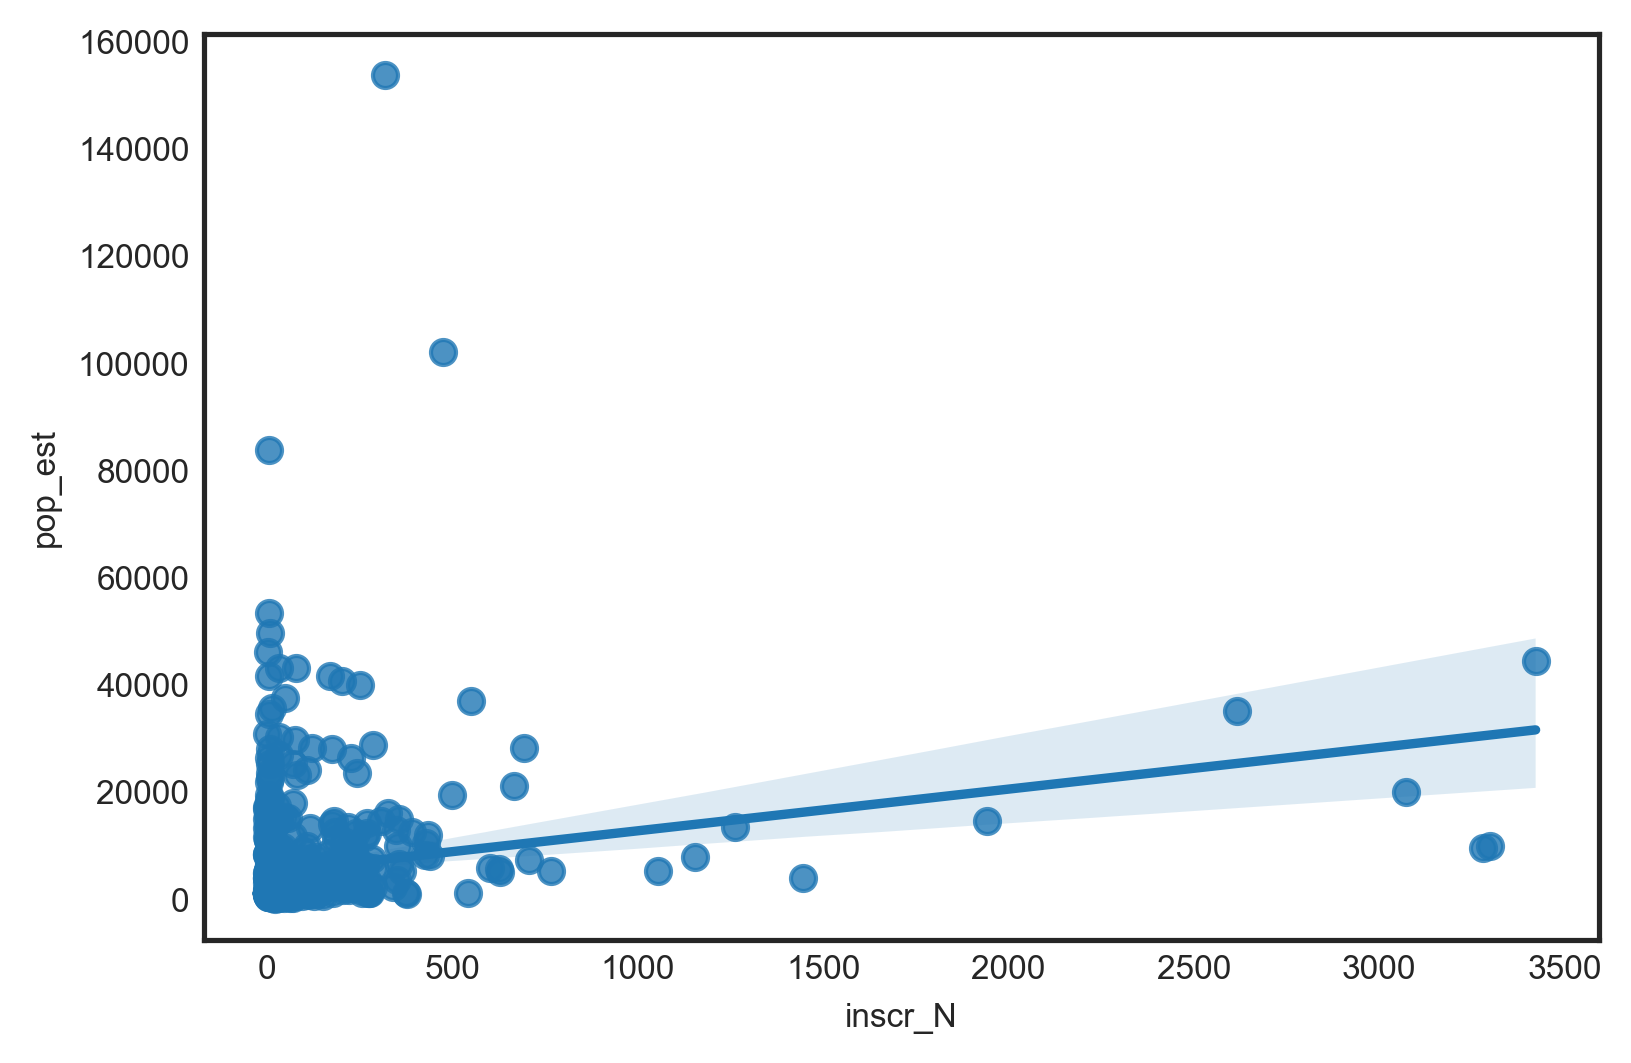

In [37]:
# cities without Roma
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="pop_est", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='pop_est_log'>

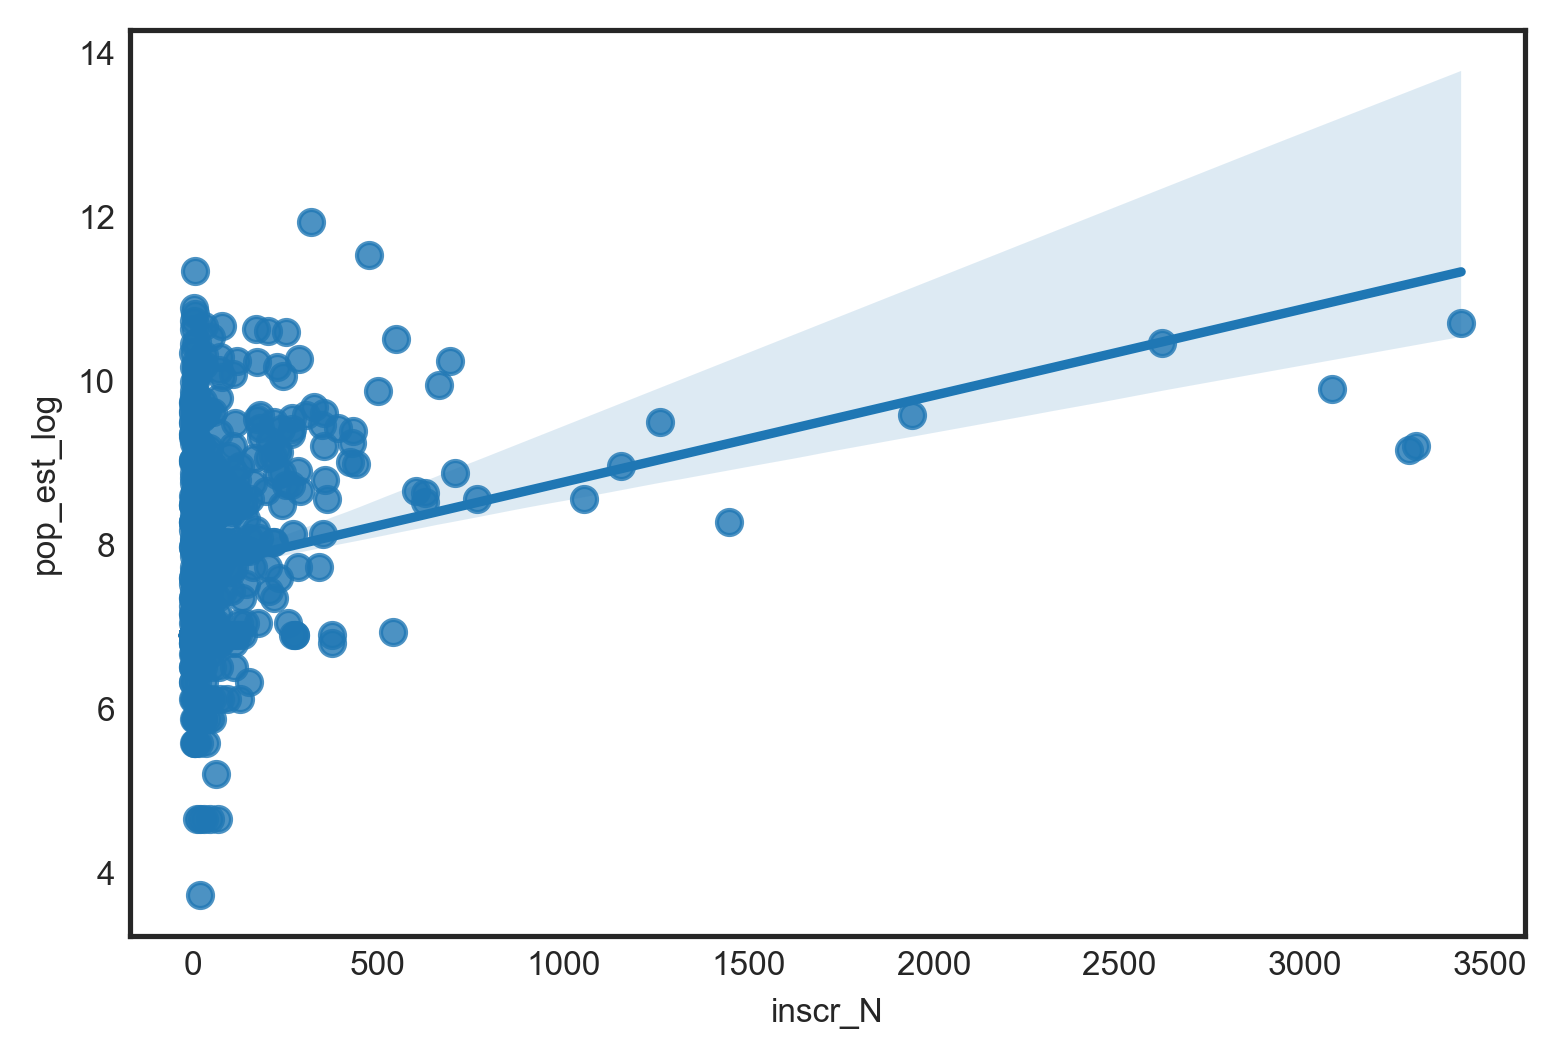

In [38]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="pop_est_log", data=data)

<AxesSubplot:xlabel='inscr_N_log', ylabel='pop_est_log'>

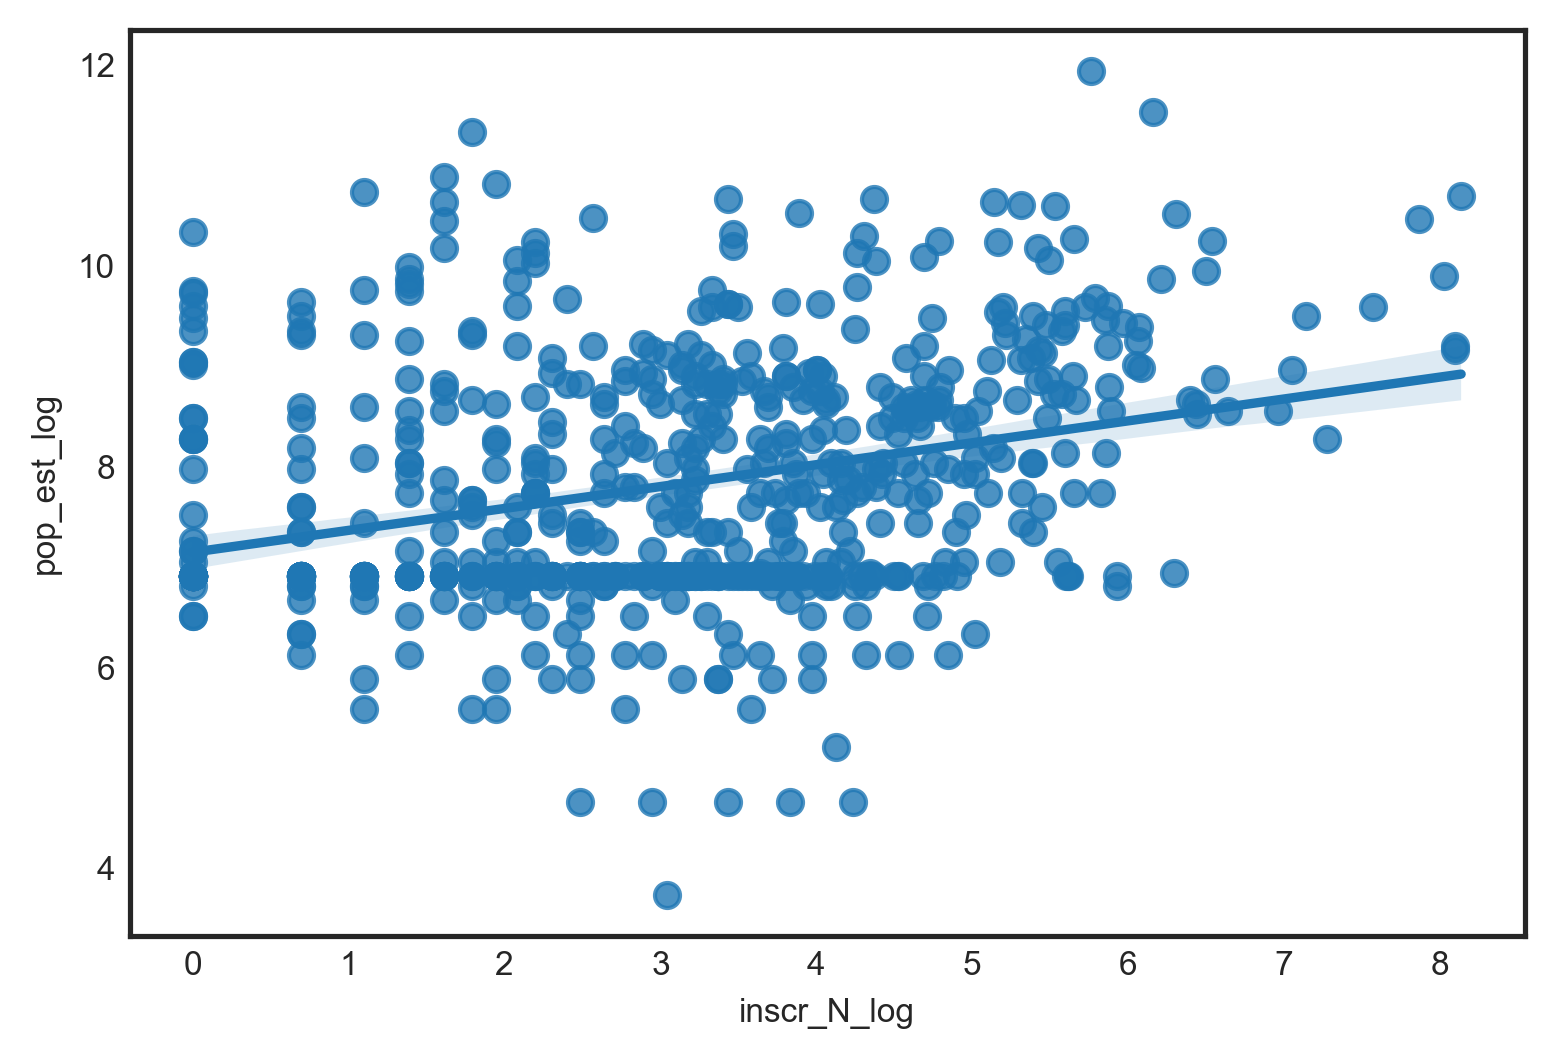

In [39]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N_log", y="pop_est_log", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='num_of_structures'>

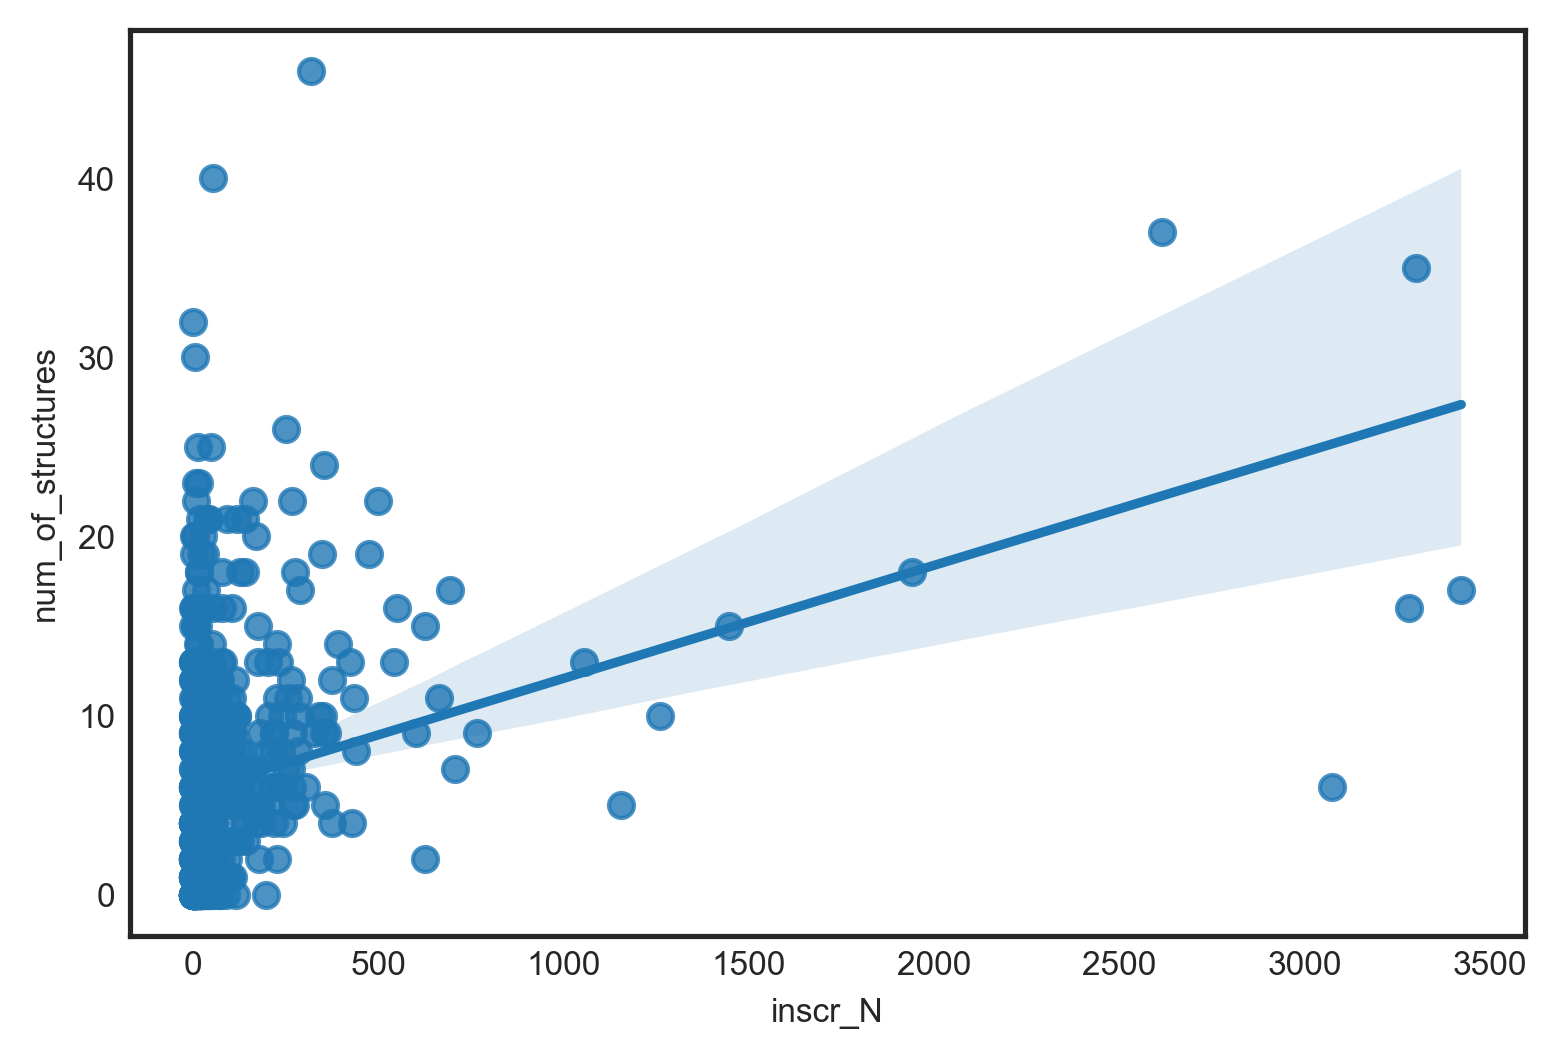

In [40]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="num_of_structures", data=data)

<AxesSubplot:xlabel='occups_N', ylabel='num_of_structures'>

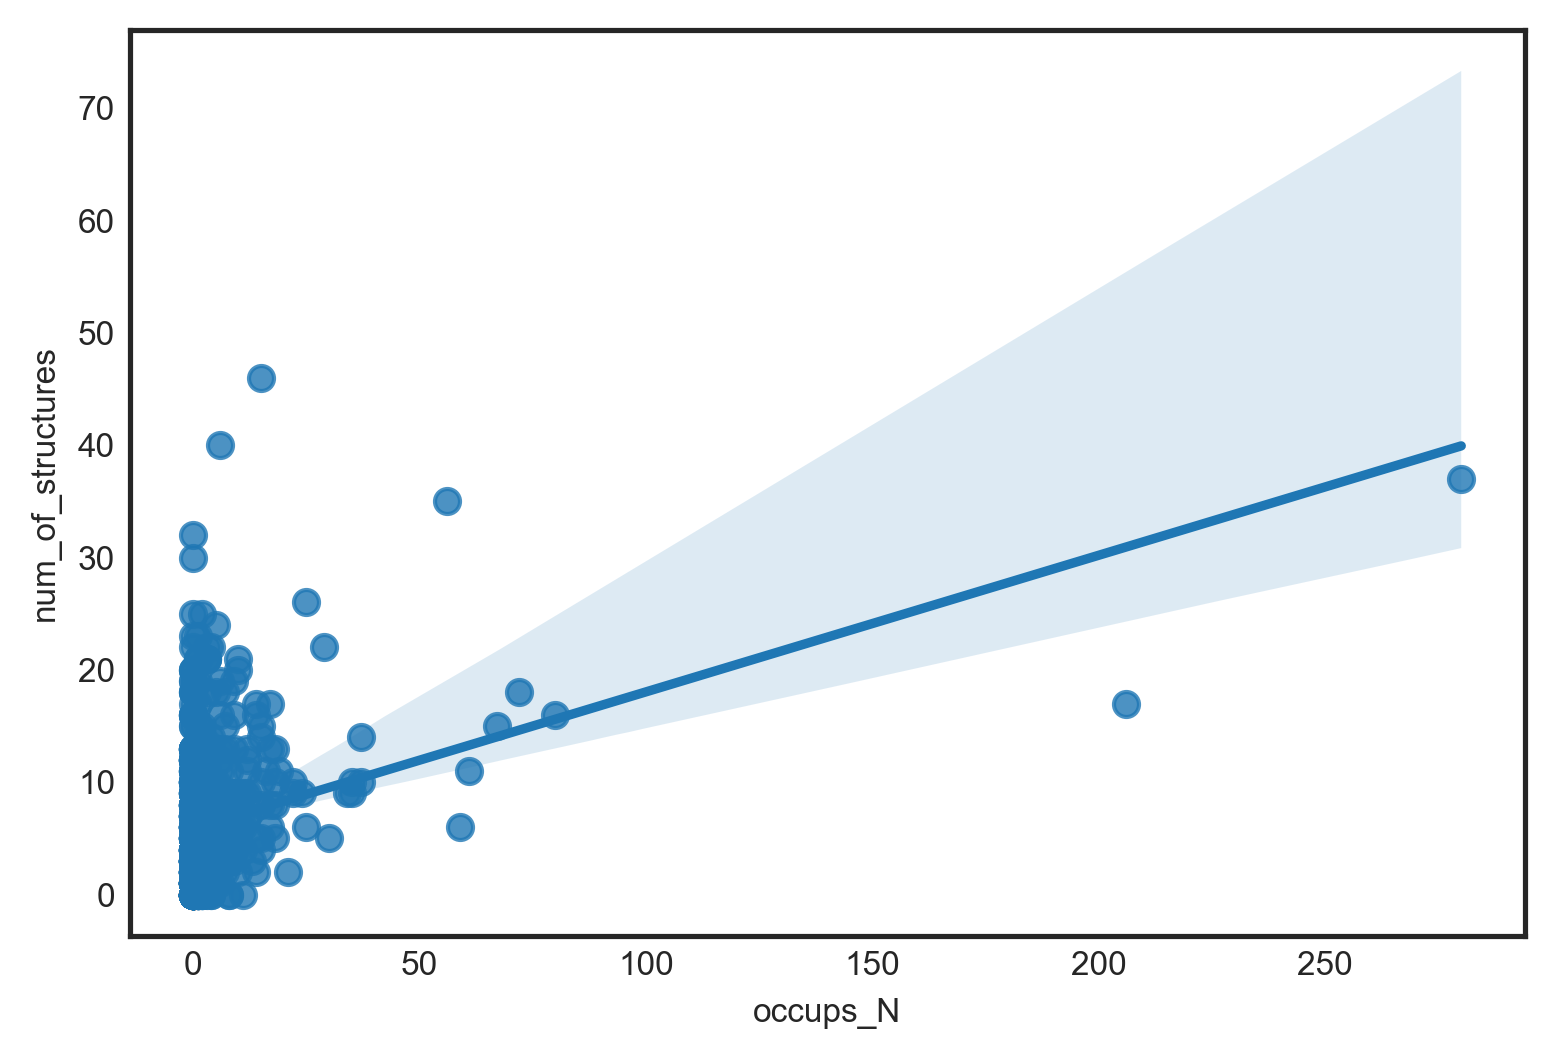

In [41]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    ]
sns.regplot(x="occups_N", y="num_of_structures", data=data)

<AxesSubplot:xlabel='occups_N', ylabel='num_of_structures'>

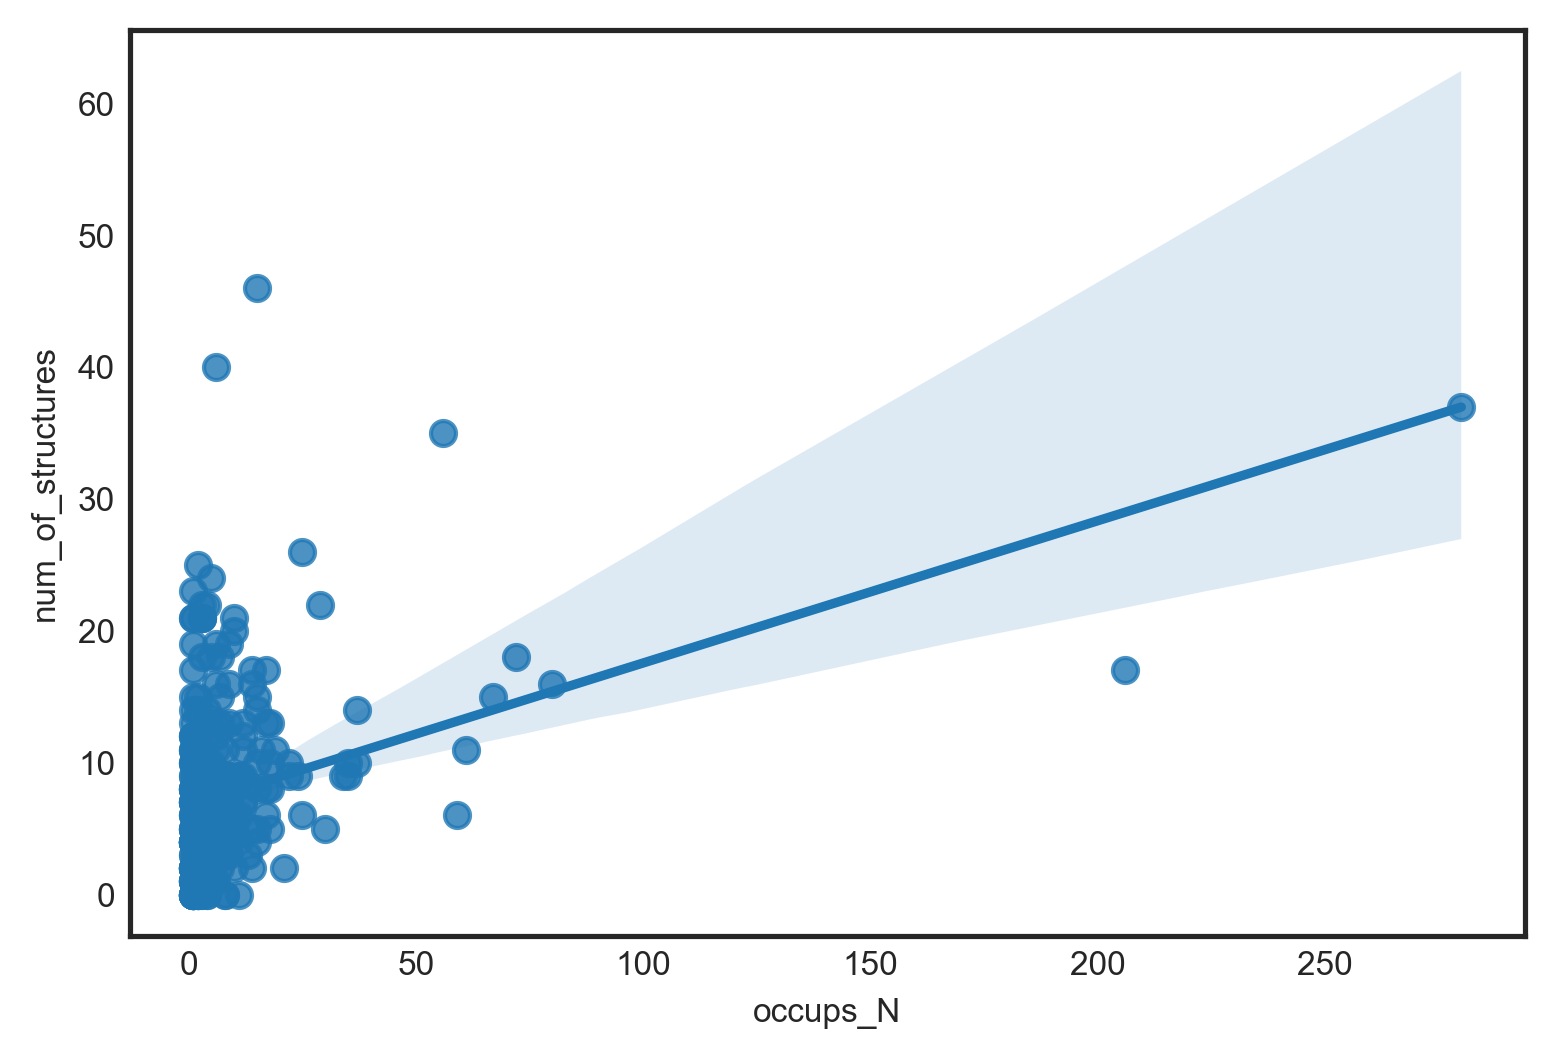

In [42]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    & (roman_cities["occups_N"]>0)
]
sns.regplot(x="occups_N", y="num_of_structures", data=data)

<AxesSubplot:xlabel='occups_N_log', ylabel='pop_est_log'>

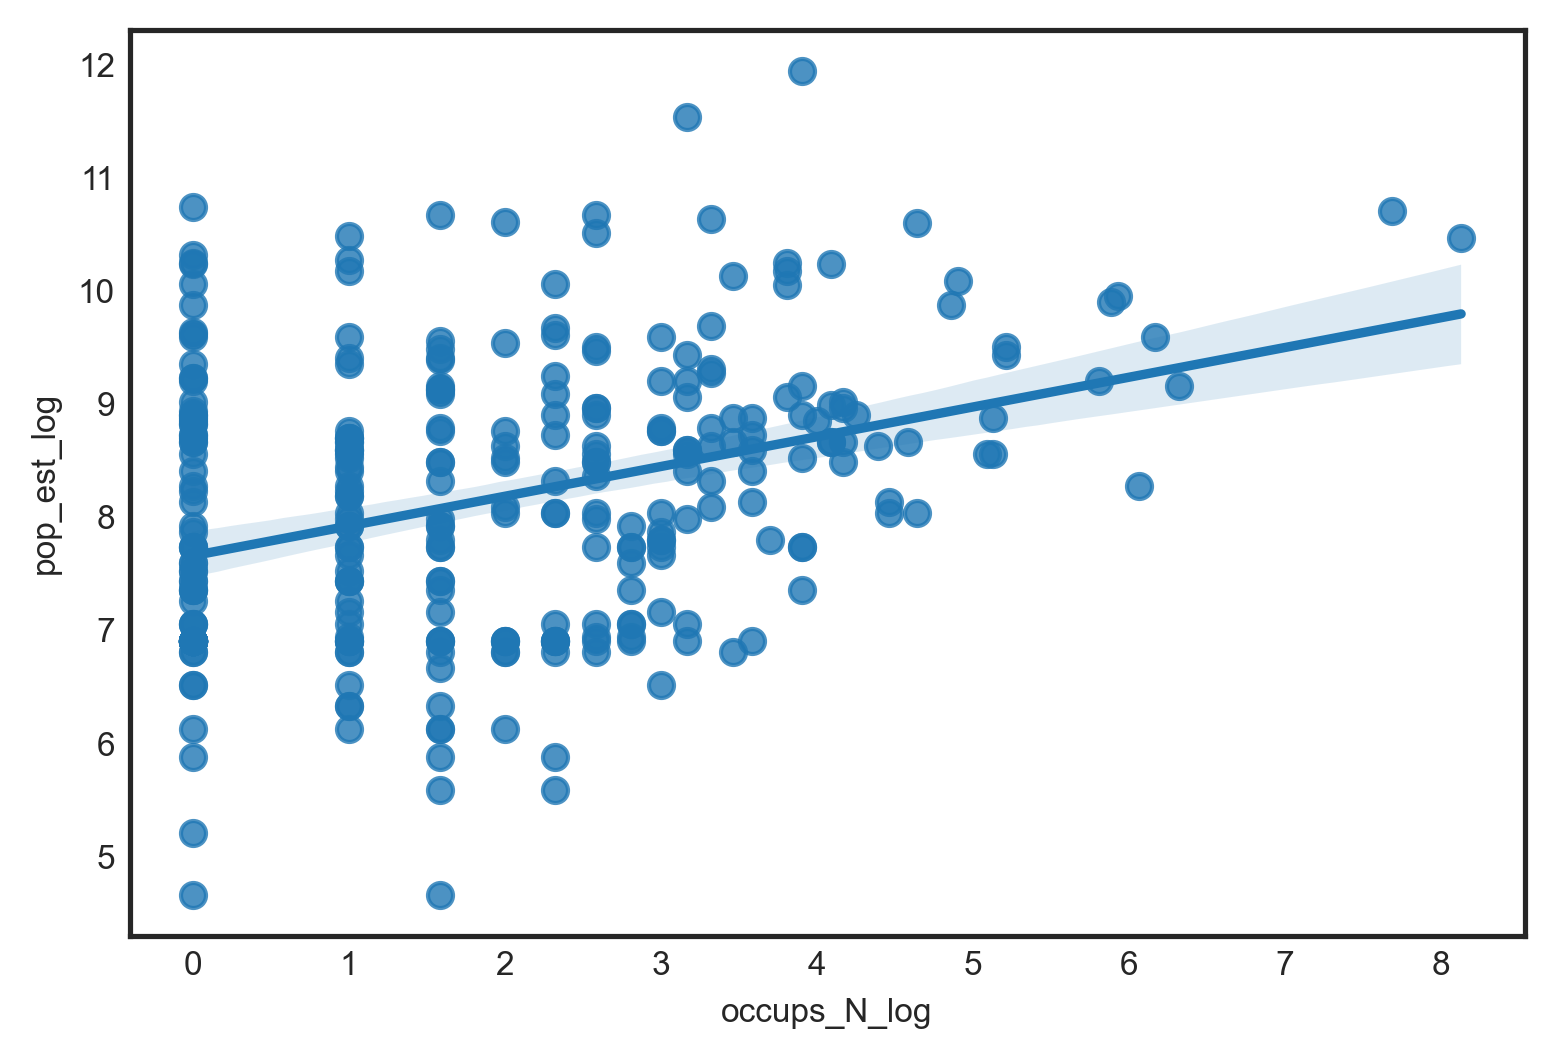

In [43]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    & (roman_cities["occups_N"]>0)
]
sns.regplot(x="occups_N_log", y="pop_est_log", data=data)

# Measuring Specialization and Diversity

In [44]:
len(roman_cities)

889

In [45]:
(roman_cities["occups_N"]>0).sum()

313

In [46]:
roman_cities["occups_N"].max()

1855.0

In [96]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [97]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list,pop_est_log,inscr_N_log,pop_est_log10,inscr_N_log2,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,"54970 True Name: occups_N, dtype: bool",[curator],1.0,[Administrative and managerial workers],6.907755,0.000000,3.000000,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,5.0,879 False 880 False 882 False 8...,"[scaenicus, curator, tonsor, possessor, faber]",5.0,"[Professional, technical and related workers, ...",8.905987,3.806662,3.867821,5.491853,2.321928
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,9.0,857 False 858 False 859 False 8...,"[curator, mesor, curator, mensor, agrimensor, ...",9.0,"[Administrative and managerial workers, Profes...",11.533453,6.163315,5.008915,8.891784,3.169925
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.0,1115 False 1116 False 1117 False 1118...,[sartor],1.0,"[Agricultural, animal husbandry and forestry w...",6.907755,2.639057,3.000000,3.807355,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.0,875 False 1133 False 1387 False 1...,"[faber, faber]",2.0,"[Production and related workers, transport equ...",10.480803,2.564949,4.551755,3.700440,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.0,49004 False 49005 False 49006 Fals...,[faber],1.0,"[Production and related workers, transport equ...",10.247432,4.787492,4.450403,6.906891,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.0,49009 False 49010 False 49011 Fals...,[faber],1.0,"[Production and related workers, transport equ...",9.351579,1.791759,4.061339,2.584963,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.0,49012 False 128502 False 128503 Fals...,"[curator, curator]",2.0,"[Administrative and managerial workers, Admini...",8.521584,3.367296,3.700877,4.857981,1.000000
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.0,128341 False 128342 False 128343 Fals...,[forensis],1.0,[Administrative and managerial workers],8.405367,3.332205,3.650405,4.807355,0.000000


In [98]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [99]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclear meaning',
 'Water-Management'}

In [101]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Building',
 'Education',
 'Glass-Working',
 'Transport',
 'Household Goods',
 'Death-care sector',
 'Unclear meaning',
 'Miscellaneous Services',
 'Performing Arts',
 'Food-Retail',
 'Clothing',
 'Fuel / Raw material',
 'Managerial',
 'Finance',
 'Food-Production',
 'Plastic Arts',
 'Water-Management',
 'Retail',
 'Metal-Working']

In [102]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [103]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

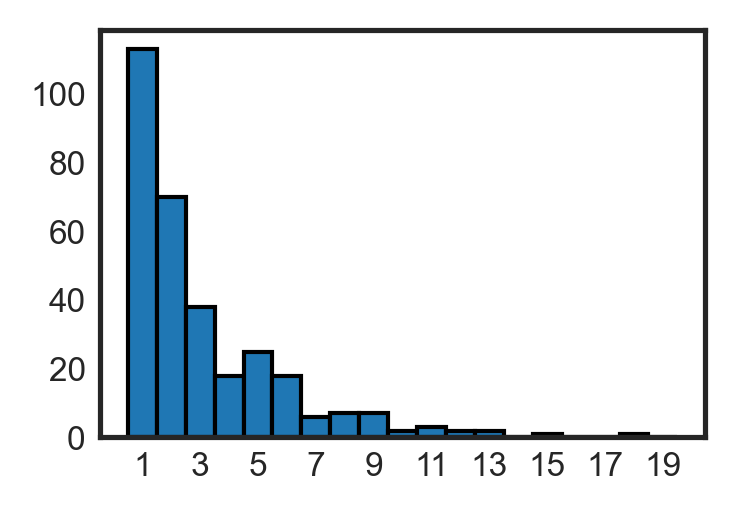

In [104]:
fig, ax = plt.subplots(figsize=(2.6, 1.8))
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)

In [105]:
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

In [106]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165     [Performing Arts, Managerial, Miscellaneous Se...
171     [Managerial, Miscellaneous Services, Manageria...
174                              [Miscellaneous Services]
177                        [Metal-Working, Metal-Working]
                              ...                        
1297                                      [Metal-Working]
1311                                      [Metal-Working]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 313, dtype: object

# Specialization

In [107]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)

In [108]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
165     [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, ...
171     [0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
177     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1315    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...
1317    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1321    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...
Name: occups_cats_vec, Length: 313, dtype: object

In [109]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.66666666...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [141]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.000000
165     0.400000
171     0.666667
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: ZI, Length: 313, dtype: float64

In [118]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI_cat, Length: 313, dtype: object

In [127]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Building', 287, 0.06420581655480985],
 1: ['Education', 216, 0.04832214765100671],
 2: ['Glass-Working', 8, 0.0017897091722595079],
 3: ['Transport', 133, 0.029753914988814318],
 4: ['Household Goods', 36, 0.008053691275167786],
 5: ['Death-care sector', 0, 0.0],
 6: ['Unclear meaning', 4, 0.0008948545861297539],
 7: ['Miscellaneous Services', 592, 0.13243847874720358],
 8: ['Performing Arts', 166, 0.03713646532438479],
 9: ['Food-Retail', 54, 0.012080536912751677],
 10: ['Clothing', 290, 0.06487695749440715],
 11: ['Fuel / Raw material', 1, 0.00022371364653243848],
 12: ['Managerial', 1059, 0.23691275167785236],
 13: ['Finance', 68, 0.015212527964205816],
 14: ['Food-Production', 212, 0.04742729306487696],
 15: ['Plastic Arts', 53, 0.01185682326621924],
 16: ['Water-Management', 14, 0.003131991051454139],
 17: ['Retail', 303, 0.06778523489932886],
 18: ['Metal-Working', 974, 0.21789709172259508]}

In [121]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([6.42058166e-02, 4.83221477e-02, 1.78970917e-03, 2.97539150e-02,
       8.05369128e-03, 0.00000000e+00, 8.94854586e-04, 1.32438479e-01,
       3.71364653e-02, 1.20805369e-02, 6.48769575e-02, 2.23713647e-04,
       2.36912752e-01, 1.52125280e-02, 4.74272931e-02, 1.18568233e-02,
       3.13199105e-03, 6.77852349e-02, 2.17897092e-01])

In [122]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.51013513...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.03378378...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.55067567...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_weighted_vec, Length: 313, dtype: object

In [123]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159     4.220963
165     5.385542
171     5.033784
174     7.550676
177     4.589322
          ...   
1297    4.589322
1311    4.589322
1315    4.220963
1317    4.220963
1321    4.220963
Name: RZI, Length: 313, dtype: float64

In [129]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165            Performing Arts
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 313, dtype: object

In [130]:
roman_cities_wo.sort_values("RZI", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N_log2,occups_N_log,occups_cats_unique_N,occups_cats_vec,shares_vec,RI,shares_weighted_vec,RZI,ZI_cat,RZI_cat
966,Hanson2016_967,Castrum Novum (Italia (VII Etruria)),Torre Chiaruccia,Italia (VII Etruria),Italy,3,44 A1,-400,NaN,Beloch 1880; BNP; Cornell and Mathews 1982; de...,...,4.754888,0.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.339623,Plastic Arts,Plastic Arts
1053,Hanson2016_1054,Iulium Carnicum,Zuglio,Italia (X Venetia et Histria),Italy,4 or 5,19 F3,-50,NaN,Beloch 1880; de Ligt 2012; PECS; Salmon 1969; ...,...,6.539159,0.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",65.735294,Finance,Finance
695,Hanson2016_696,Clunia,Peñalba de Castro,Hispania Tarraconensis,Spain,2,25 B4,14,NaN,BNP; Carreras Monfort 1995-1996; DGRG; PECS; S...,...,7.900867,1.000000,2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,"[7.787456445993031, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",42.169811,Building,Plastic Arts
660,Hanson2016_661,Colonia Ulpia Traiana,Xanten,Germania Inferior,Germany,3,11 G1,14,NaN,Benario 1981; Golvin 1988; McEvedy 2011; PECS;...,...,7.499846,1.000000,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...",0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.77533783...",42.169811,Miscellaneous Services,Plastic Arts
1010,Hanson2016_1011,Caesena,Cesena,Italia (VIII Aemilia),Italy,4 or 5,40 C4,-200,NaN,Beloch 1880; de Ligt 2012; PECS.,...,4.000000,1.584963,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, ...",0.666667,"[0.0, 0.0, 0.0, 0.0, 41.38888888888888, 0.0, 0...",41.388889,Managerial,Household Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,Hanson2016_958,Urvinum Mataurense,Urbino,Italia (VI Umbria and Ager Gallicus),Italy,3,42 D1,-400,NaN,Beloch 1880; Bispham 2007; BNP; de Ligt 2012; ...,...,5.857981,2.807355,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, ...","[0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.428571,"[2.2249875559980086, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.224988,Metal-Working,Building
844,Hanson2016_845,Venusia,Venosa,Italia (II Apulia et Calabria),Italy,3,45 C3,-400,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,8.479780,3.321928,5,"[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",0.300000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.51013513...",2.108491,Managerial,Food-Production
872,Hanson2016_873,Aesernia,Isernia,Italia (IV Samnium),Italy,3,44 F2,-400,NaN,Beloch 1880; Bispham 2007; BNP; Cornell and Ma...,...,7.781360,3.906891,5,"[0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 4, 0, 0, ...","[0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0,...",0.333333,"[0.0, 1.3796296296296298, 0.0, 0.0, 0.0, 0.0, ...",2.055172,Metal-Working,Clothing
746,Hanson2016_747,Aquinum,Aquino,Italia (I Latium and Campania),Italy,2,44 E3,-400,NaN,Beloch 1880; Bispham 2007; Cornell and Mathews...,...,8.614710,5.209453,8,"[1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 17, 0, 1,...","[0.02702702702702703, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.459459,"[0.420943591675299, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",1.939361,Managerial,Managerial


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<AxesSubplot:xlabel='occups_N_log', ylabel='RZI'>

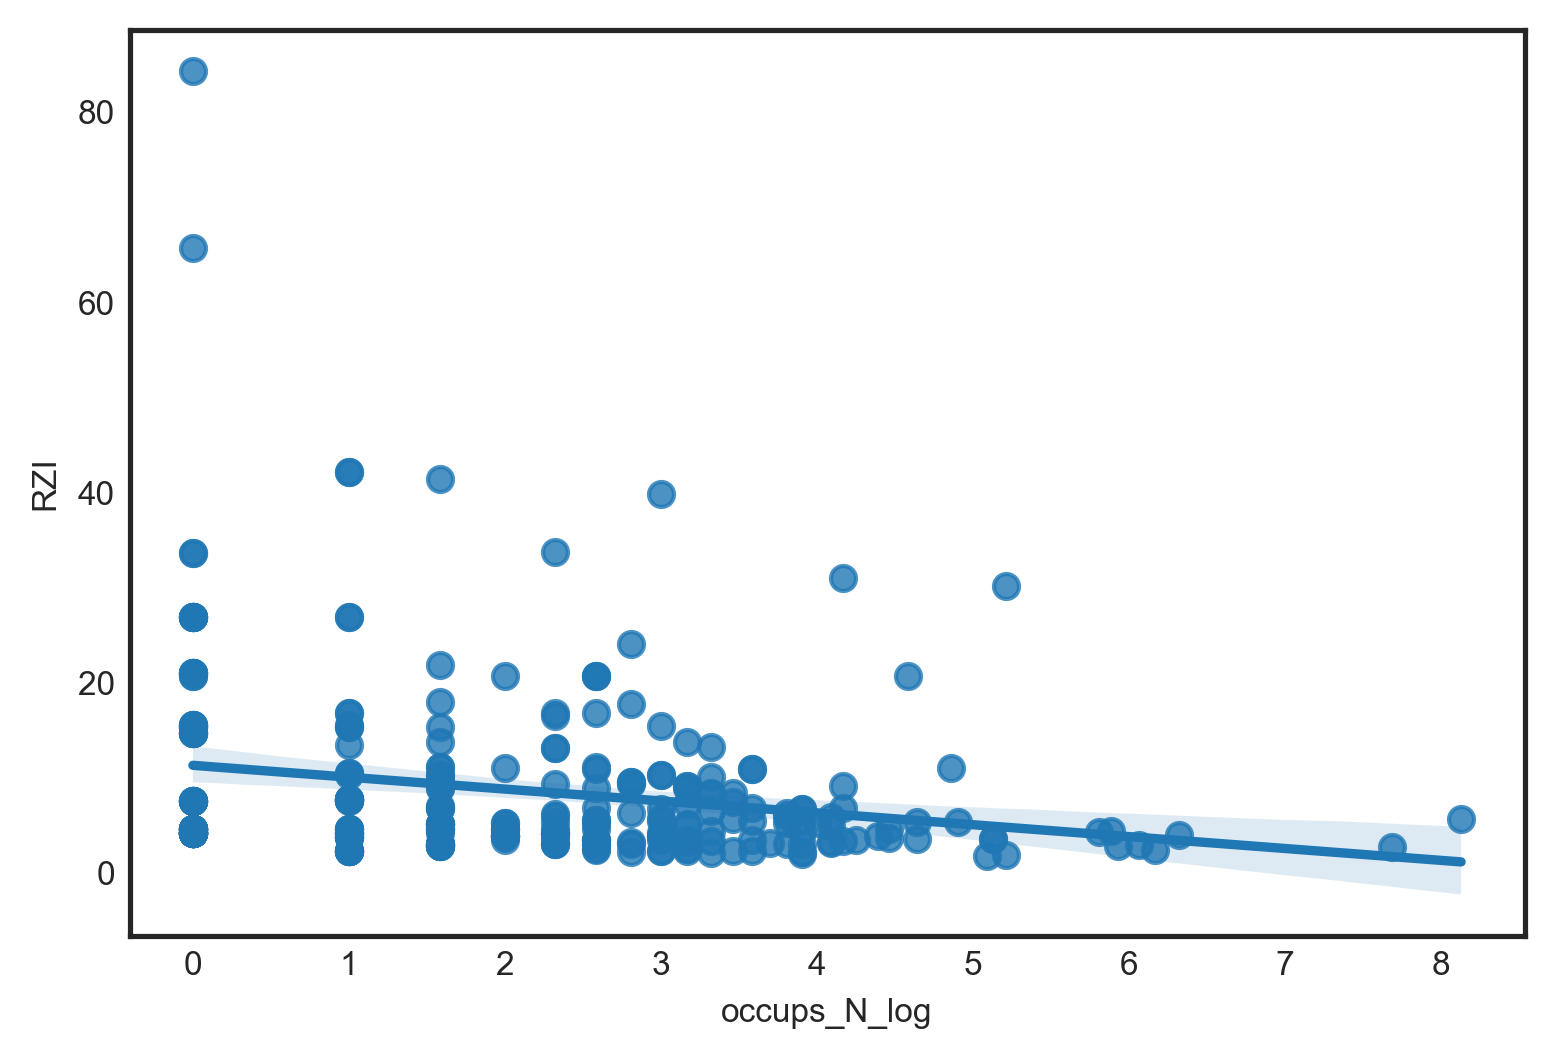

In [131]:
# cities without Roma, POP LOG
data=roman_cities_wo[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="occups_N_log", y="RZI", data=data)

In [132]:
# shares squared:

def get_shares_squared(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = (a**2) / sum(a)
    return a
roman_cities_wo["shares_squared_vec"] = roman_cities_wo["occups_cats_vec"].apply(get_shares_squared)
roman_cities_wo["shares_squared_vec"]

159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ...
171     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_squared_vec, Length: 313, dtype: object

In [133]:
roman_cities_wo["ZI2"] = roman_cities_wo["shares_squared_vec"].apply(max)
roman_cities_wo["ZI2"]

159     1.0
165     0.8
171     4.0
174     1.0
177     2.0
       ... 
1297    1.0
1311    1.0
1315    2.0
1317    1.0
1321    2.0
Name: ZI2, Length: 313, dtype: float64

In [134]:
roman_cities_wo["ZI2_cat"] = roman_cities_wo["shares_squared_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI2_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI2_cat, Length: 313, dtype: object

In [135]:
def get_rzi2(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = (a**2) / sum(a)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    RZI2 = max(shares_weighted)
    return RZI2

roman_cities_wo["RZI2"] = roman_cities_wo["occups_cats_vec"].apply(get_rzi2)
roman_cities_wo["RZI2"]

159      4.220963
165      5.385542
171     30.202703
174      7.550676
177      9.178645
          ...    
1297     4.589322
1311     4.589322
1315     8.441926
1317     4.220963
1321     8.441926
Name: RZI2, Length: 313, dtype: float64

In [136]:
roman_cities_wo["ZI2_cat"] = roman_cities_wo["shares_squared_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])
roman_cities_wo["ZI2_cat"]

159                 Managerial
165                 Managerial
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: ZI2_cat, Length: 313, dtype: object

In [137]:
roman_cities_wo.sort_values("RZI2", ascending=False)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,shares_vec,RI,shares_weighted_vec,RZI,ZI_cat,RZI_cat,shares_squared_vec,ZI2,ZI2_cat,RZI2
991,Hanson2016_992,Roma,Rome,Italia (VII Etruria),Italy,1,43 B2,-700,NaN,Beloch 1886; Benario 1981; de Ligt 2012; Golvi...,...,"[0.0646900269541779, 0.05929919137466307, 0.00...",0.266846,"[1.0075415347915513, 1.2271638215034442, 1.807...",2.409704,Managerial,Fuel / Raw material,"[7.762803234501348, 6.522911051212938, 0.01940...",132.088949,Managerial,557.542588
787,Hanson2016_788,Ostia,Ostia,Italia (I Latium and Campania),Italy,2,43 B2,-350,NaN,Beloch 1880; Boatwright 2000; Cornell and Math...,...,"[0.125, 0.04642857142857143, 0.0, 0.1678571428...",0.242857,"[1.9468641114982577, 0.9608134920634921, 0.0, ...",5.641515,Metal-Working,Transport,"[4.375, 0.6035714285714285, 0.0, 7.88928571428...",16.514286,Metal-Working,265.151182
663,Hanson2016_664,Andematunum,Langres,Germania Superior,France,3,18 C2,-27,NaN,Bedon 2001; Bedon et al 1988; BNP; DGRG; PECS;...,...,"[0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000,"[1.297909407665505, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",20.694444,Food-Retail,Food-Retail,"[0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.500000,Food-Retail,124.166667
1287,Hanson2016_1288,Augusta Vindelicum,Augsburg,Raetia,Germany,2,12 D4,-15,NaN,BNP; Boatwright 2000; McEvedy 2011; PECS; Quin...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.900000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13.277228,Retail,Retail,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.100000,Retail,119.495050
724,Hanson2016_725,Saguntum,Sagunto,Hispania Tarraconensis,Spain,3,27 E2,-210,NaN,BNP; Brunt 1971; Carreras Monfort 1995-1996; C...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.589322,Metal-Working,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.000000,Metal-Working,100.965092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,Hanson2016_1070,Laumellum,Lomello,Italia (XI Transpadana),Italy,4 or 5,39 D3,-27,NaN,de Ligt 2012; DGRG.,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Managerial,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Managerial,2.294661
504,Hanson2016_505,Aequum,?itluk,Dalmatia,Croatia,3,20 D6,45,NaN,BNP; PECS; Salmon 1969; Wilkes 2003a; Wilkes 2...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Managerial,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Managerial,2.294661
471,Hanson2016_472,Turris Libisonis,Portocorres,Corsica et Sardinia,Italy,3,48 A2,-42,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Managerial,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Managerial,2.294661
397,Hanson2016_398,Lindum,Lincoln,Britannia,United Kingdom,3,8 G1,90,NaN,McEvedy 2011; Millett 1990: Table 4.4; Millett...,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.294661,Managerial,Metal-Working,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500000,Managerial,2.294661


In [138]:
roman_cities_wo.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Select Bibliography', 'Area',
       'Estimate Basis', 'num_of_structures', 'ID', 'level_0', 'Unnamed: 0_y',
       'index', 'pop_sample', 'pop_est', 'pop_diff', 'western_province',
       'geometry', 'inscr_N', 'inscr_texts_wordlist', 'edcs_ids', 'edh_ids',
       'inscr_with_occups', 'occups_mask', 'occups_list', 'occups_N',
       'occups_cats_list', 'pop_est_log', 'inscr_N_log', 'pop_est_log10',
       'inscr_N_log2', 'occups_N_log', 'occups_cats_unique_N',
       'occups_cats_vec', 'shares_vec', 'RI', 'shares_weighted_vec', 'RZI',
       'ZI_cat', 'RZI_cat', 'shares_squared_vec', 'ZI2', 'ZI2_cat', 'RZI2'],
      dtype='object')

In [147]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N',
 'ZI', 'RZI','ZI2','RZI2']]

In [148]:
roman_cities_wo_quant.corr()

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZI,RZI,ZI2,RZI2
Area,1.000000,0.526580,0.979396,0.806295,0.248682,0.241001,0.261727,0.235602,0.168868,-0.087371,-0.070376,0.203126,0.168890
num_of_structures,0.526580,1.000000,0.515954,0.493718,0.369120,0.386404,0.359147,0.342420,0.297782,-0.194211,-0.100667,0.264009,0.246609
pop_est,0.979396,0.515954,1.000000,0.697050,0.226469,0.230439,0.242894,0.238923,0.163219,-0.118194,-0.076101,0.189466,0.152144
pop_est_log,0.806295,0.493718,0.697050,1.000000,0.297635,0.362208,0.276893,0.350447,0.335519,-0.261921,-0.062396,0.186904,0.170100
inscr_N,0.248682,0.369120,0.226469,0.297635,1.000000,0.631435,0.773520,0.598477,0.691339,-0.363819,-0.049288,0.479123,0.465662
inscr_N_log,0.241001,0.386404,0.230439,0.362208,0.631435,1.000000,0.470132,0.721461,0.695023,-0.623856,-0.066052,0.323833,0.317745
occups_N,0.261727,0.359147,0.242894,0.276893,0.773520,0.470132,1.000000,0.626764,0.663122,-0.334607,-0.103790,0.639170,0.658283
occups_N_log,0.235602,0.342420,0.238923,0.350447,0.598477,0.721461,0.626764,1.000000,0.881147,-0.747541,-0.217175,0.536822,0.414519
occups_cats_unique_N,0.168868,0.297782,0.163219,0.335519,0.691339,0.695023,0.663122,0.881147,1.000000,-0.770241,-0.104770,0.327875,0.341575
ZI,-0.087371,-0.194211,-0.118194,-0.261921,-0.363819,-0.623856,-0.334607,-0.747541,-0.770241,1.000000,0.113997,0.016883,-0.106942


In [149]:
# task: transform to heatmap: https://stackoverflow.com/questions/39409866/correlation-heatmap